# Analyzing Tweets from Airline Passengers using Python's NLTK package and other useful libraries

*This is a notebook by Ogechi Anoliefo.*

## Steps:
<a href="#importing-libraries" style="text-decoration:none">1. Import Libraries</a>


<a href="#tweets-mining" style="text-decoration:none">2. Tweets Mining</a>


<a href="#data-cleaning" style="text-decoration:none">3. Data Cleaning</a>


<a href="#sentiment-analysis" style="text-decoration:none">4. Sentiment Analysis</a>
  

<a href="#time-series-analysis" style="text-decoration:none">5. Time Series Analysis</a>

<a href="#tweets-processing" style="text-decoration:none">6. Tweets Processing</a>  

<a href="#word-cloud" style="text-decoration:none">7. Word Cloud</a>  

### 1. Import Libraries <a id='importing-libraries'></a> 

In [1]:
## IMPORTING THE LIBRARIES TO BE USED IN THIS PROJECT

import pandas as pd #primary data structure library
import numpy as np #for working with arrays and carrying out mathematical operations
import requests #for making HTTP requests
import json #for encoding and decoding json data
from collections import Counter #for counting
import glob #to find files/paths that match a specified pattern
import os #for interacting with the operating system

#for scraping tweets from X
import asyncio
import twscrape
from twscrape import API, gather
from twscrape.logger import set_log_level

#for processing textual data
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from textblob import TextBlob
import re
import string
import sys
from unicodedata import category
import demoji

#for creating visualizations
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
from wordcloud import WordCloud
from PIL import Image 
import folium 
import random
import kaleido

#needed to display my plotly chart in my website/blog post
import chart_studio
username = "oge"
api_key = "4hXyGGJ6Fvvh9xWwSnwG"
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)
import chart_studio.plotly as py
import chart_studio.tools as tls

#for location geocoding
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

### 2. Tweets Mining <a id='tweets-mining'></a> 

To mine the tweets, I made use of the Python library **twscrape**. The library works through an authorised API, so you will need X account(s) in order to use it. You need your X username and password, and also the email associated with your X account and its password to be able to mine tweets. 

The library is designed to automatically switch accounts when the X API limit has been reached per 15-minute interval. So you can add multiple accounts to the API pool in order to change to a different account and continue scraping when the other accounts have reached their API limits. I used two accounts in order to make scraping faster and stored the mined tweets in csv files.

If you would like to read more about twscrape, and how you can use it to scrape tweets, you can check out their official documentations [here](https://pypi.org/project/twscrape/) and [here](https://github.com/vladkens/twscrape).

The code block below illustrates how to add the required credentials. **@username, password, email and email_pass** represent **your X account username, your X account password, the email associated with your X account and its password** respectively. 

In [2]:
#credentials required to use twscrape
api = API()  #create an instance of the twscrape API object 
await api.pool.add_account("@username", "password", "email", "email_pass") #add X account and email credentials 
await api.pool.add_account("@username", "password", "email", "email_pass") #add X account and email credentials
await api.pool.login_all()  #logs in to all the accounts provided 

For my analysis, I focused on six Nigerian airlines, namely: Aero Contractors, Air Peace, Dana Air, Ibom Air, Max Air and United Nigeria Airline. I wanted to mine tweets which were created between 1st and 28th December 2023, mentioning any of the 6 airlines or their X handles. I created a function which would take in the search query, airline name and the directory to save the output on my desktop, and return a dataframe of the scraped tweets.

You will notice that my function is defined using **async def**. This is because twscrape uses a coroutine function to scrape tweets, so using the regular **def** for defining regular python functions will not work. ie. **async def** is used to define coroutine functions in python.

To get the result from the *scrape_tweets* function, I had to use the **await** expression. This will get the result of the coroutine object that the *scrape_tweets* function returns. Note that calling the function like a regular python function: **scrape_tweets(xxxxx, xxxxx, xxxxxxx)** will not apply the function or output the result. You would only get a message indicating that a coroutine object has been created.

In [3]:
#FUNCTION TO SCRAPE TWEETS AND SAVE TO A DIRECTORY ON THE SYSTEM
async def scrape_tweets(search_query, airline, save_to_file):
    
    data = []  #create an empty list to be used to store the search results
    
    #define the search query. Include start date and end date
    q = search_query + "since:2023-12-01 until:2023-12-29"
    
    
    async for tweet in api.search(q, limit=50000): #iterate over the search results
        c = [tweet.id, tweet.date, tweet.rawContent, tweet.likeCount, tweet.retweetCount, tweet.user.location] #list of attributes to return 
        data.append(c)  #add each new list of attributes to 'data'
    
    df = pd.DataFrame(data, columns=['Tweet_ID', 'Time_Created', 'Text', 'Likes', 'Retweets', 'Location']) #convert the list to a dataframe
    df['Airline'] = airline  #add a new column 'Airline' to the dataframe to specify the airline whose tweets have been returned
    df.to_csv(save_to_file, index = False)  #save to a chosen directory on the computer
    return df

In [4]:
#an example of how the scrape_tweets function works
tweets = await scrape_tweets("danaair OR @danaair OR #danaair", "Dana Air", "Airlines\Dana_Air_X.csv")
tweets

Tweet_ID         Time_Created  \
0    1730451868705341651  2023-12-01 05:00:50   
1    1730482961307316428  2023-12-01 07:04:23   
2    1730486857673171328  2023-12-01 07:19:52   
3    1730487140285333798  2023-12-01 07:20:59   
4    1730487624656204039  2023-12-01 07:22:55   
..                   ...                  ...   
823  1740470423220084880  2023-12-28 20:30:59   
824  1740476099501650322  2023-12-28 20:53:33   
825  1740480707523424347  2023-12-28 21:11:51   
826  1740486570321514699  2023-12-28 21:35:09   
827  1740510825939644559  2023-12-28 23:11:32   

                                                  Text  Likes  Retweets  \
0    @NosaMUgiagbe @DanaAir Blood of Jesus. Brother...      0         0   
1                      @theakuko @DanaAir Ok thank you      1         0   
2    It’s been a month @DanaAir cancelled my flight...      1         0   
3    @Mzwayne007 @DanaAir my details are in the com...      0         0   
4    @DanaAir here’s my details. Give me my refund....      0         0   
..                                                 ...    ...       ...   
823  @BONILENLA_ @DanaAir @fkeyamo @FAAN_Official O...      0         0   
824  @HeemOnWheels @flyunitedng @DanaAir 118,000,00...      1         0   
825  @HeemOnWheels @flyunitedng @DanaAir Today is d...      1         0   
826  @DanaAir This airline needs to be thrown out o...      0         0   
827  @HeemOnWheels @NOgechukwu @flyunitedng @DanaAi...      2         0   

                  Location   Airline  
0                           Dana Air  
1                           Dana Air  
2                  Nigeria  Dana Air  
3                  Nigeria  Dana Air  
4                  Nigeria  Dana Air  
..                     ...       ...  
823         Abuja, Nigeria  Dana Air  
824                         Dana Air  
825  Konoha, Leaf Village   Dana Air  
826             Peacefull   Dana Air  
827         Lagos, Nigeria  Dana Air  

[828 rows x 7 columns]

I used the function to scrape tweets for each airline, and store them in csv files. The commands were as follows:  

tweets = await scrape_tweets("aerocontractors OR @flyaero OR #flyaero", "Aero Contractors", "Airlines\Aero.csv") ----for Aero Contractors  
tweets = await scrape_tweets("airpeace OR @flyairpeace OR #airpeace", "Air Peace", "Airlines\Air_Peace.csv") ----for Air Peace     
tweets = await scrape_tweets("danaair OR @danaair OR #danaair", "Dana Air", "Airlines\Dana_Air.csv") ----for Dana Air    
tweets = await scrape_tweets("ibomair OR @ibomairlines OR #ibomair", "Ibom Air", "Airlines\Ibom_Air.csv") ----for Ibom Air    
tweets = await scrape_tweets("maxair OR @maxairltd OR #maxair", "Max Air", "Airlines\Max_Air.csv") ----for Max Air    
tweets = await scrape_tweets("unitednigeriaairlines OR @flyunitedng OR #unitednigeriaairlines", "United Nigeria Airline", "Airlines\United_Nigeria_Airline.csv")  ----for United Nigeria Airline  


##### Combining all tweets into one Dataframe

In [5]:
#get a list of all CSV files in the folder
folder = "Airlines"
files = glob.glob(os.path.join(folder, "*.csv"))

#read each file into a dataframe and store them in a list
dfs = []
for file in files:
    data = pd.read_csv(file)
    dfs.append(data)
    
#merge the dataframes
df = pd.concat(dfs, axis=0, ignore_index=True)    
df.head()

Tweet_ID         Time_Created  \
0  1730498287172493610  2023-12-01 08:05:17   
1  1730517986950127815  2023-12-01 09:23:34   
2  1730518283634274364  2023-12-01 09:24:44   
3  1730602557116985433  2023-12-01 14:59:37   
4  1730614023979147744  2023-12-01 15:45:11   

                                                Text  Likes  Retweets  \
0  @flyaero Please refund my money since August I...      0         0   
1  @flyaero Good morning \n\nI booked a flight ye...      0         0   
2  @flyaero \nI would greatly appreciate it if yo...      0         0   
3  @flyaero I booked for a flight and ticket was ...      0         0   
4           @TimsyMera @flyaero Did they sort this ?      0         0   

          Location           Airline  
0              NaN  Aero Contractors  
1   Abuja, Nigeria  Aero Contractors  
2   Abuja, Nigeria  Aero Contractors  
3          Nigeria  Aero Contractors  
4  On The Wheels!!  Aero Contractors

In [6]:
df.shape

(5594, 7)

### 3. Data Cleaning <a id='data-cleaning'></a> 

##### Removing duplicates

The first data cleaning step I took was to check for, and take out duplicates in the dataset. Every tweet on X has a unique tweet ID, making tweet_id the primary key column for this dataset. Using the line of code below, I checked the tweet_id column to see if there were any duplicates.


In [7]:
#checking for duplicates
df.duplicated(subset=['Tweet_ID']).sum()

220

There were 220 duplicate entries in the dataset. I used the lines of code below to drop the duplicates, and view the resulting dataset.

In [8]:
#drop duplicates
df1 = df.drop_duplicates(subset=['Tweet_ID'], keep='first').reset_index(drop=True)
df1.shape

(5374, 7)

After removing the duplicates, there were 5374 entries left in the dataset.

##### Handling missing values

In [9]:
#return the number of missing values in each column of the dataset
df1.isnull().sum()

Tweet_ID           0
Time_Created       0
Text               0
Likes              0
Retweets           0
Location        1439
Airline            0
dtype: int64

The **Location** column of the dataset contained 1439 missing values. This large number of missing values was expected as only a handful of X users include their location in their bio. I replaced the missing values in this column with '---', because if used for location geocoding, 'NaN' values would return coordinates, which should not be. 

In [10]:
#replace NaN values in 'Location' column with '---'
df1['Location'] = df1['Location'].fillna('---')
df1.head()

Tweet_ID         Time_Created  \
0  1730498287172493610  2023-12-01 08:05:17   
1  1730517986950127815  2023-12-01 09:23:34   
2  1730518283634274364  2023-12-01 09:24:44   
3  1730602557116985433  2023-12-01 14:59:37   
4  1730614023979147744  2023-12-01 15:45:11   

                                                Text  Likes  Retweets  \
0  @flyaero Please refund my money since August I...      0         0   
1  @flyaero Good morning \n\nI booked a flight ye...      0         0   
2  @flyaero \nI would greatly appreciate it if yo...      0         0   
3  @flyaero I booked for a flight and ticket was ...      0         0   
4           @TimsyMera @flyaero Did they sort this ?      0         0   

          Location           Airline  
0              ---  Aero Contractors  
1   Abuja, Nigeria  Aero Contractors  
2   Abuja, Nigeria  Aero Contractors  
3          Nigeria  Aero Contractors  
4  On The Wheels!!  Aero Contractors

In [11]:
#confirm there are no more missing values in the dataset
df1.isnull().sum()

Tweet_ID        0
Time_Created    0
Text            0
Likes           0
Retweets        0
Location        0
Airline         0
dtype: int64

##### Changing some column types

Here I looked at the column types to ensure they were in the appropriate format. I changed **Time_Created** column to datetime format.

In [12]:
#checking column types
df1.dtypes

Tweet_ID         int64
Time_Created    object
Text            object
Likes            int64
Retweets         int64
Location        object
Airline         object
dtype: object

In [13]:
#to change 'Time_Created' column to datetime format and confirm it's been changed 
df1['Time_Created'] = pd.to_datetime(df1['Time_Created'])  
df1.dtypes 

Tweet_ID                 int64
Time_Created    datetime64[ns]
Text                    object
Likes                    int64
Retweets                 int64
Location                object
Airline                 object
dtype: object

In [14]:
#checking to see the number of tweets/mentions per airline
df1.Airline.value_counts()

Airline
Air Peace                 2490
United Nigeria Airline     829
Ibom Air                   828
Dana Air                   811
Aero Contractors           257
Max Air                    159
Name: count, dtype: int64

### 4. Sentiment Analysis <a id='sentiment-analysis'></a> 

To perform sentiment analysis, I used the python library **TextBlob**. I created a function **get_sentiment** to return the sentiment category (ie. negative, positive or neutral) for each tweet based on the TextBlob polarity score. Note that the polarity score is a float within the range -1.0 to 1.0, where:  
--values between -1.0 and 0.0 indicate a negative sentiment  
--values between 0.0 and 1.0 indicate a positive sentiment  
--a value of 0.0 indicates a neutral sentiment

In [15]:
#function to return sentiment category
def get_sentiment(tweet):
    polarity = TextBlob(tweet).sentiment.polarity
    if polarity > 0:
        return "Positive"
    elif polarity < 0:
        return "Negative"
    else:
        return "Neutral"

In [16]:
#testing the get_sentiment function on some randomly selected tweets
texts = ("@flyaero didn’t disappoint me, affordable ticket with excellent customer service 🥳🥳🥳", 
         "Hello @DanaAir please check your DM asap! \n\nWhat’s with the cancelling of flight 🤷🏾‍♀️🤷🏾‍♀️🤷🏾‍♀️🤷🏾‍♀️ \n\nCc: @officialomoba",
         "@flyunitedng That’s disrespectful of you to say, na everybody dey travel like a peasant?")
for text in texts:
    print(get_sentiment(text))

Positive 
Neutral 
Negative


In [17]:
#applying the get_sentiment function to each entry in 'Text' column and storing the result in a new column 'Sentiment'
df1['Sentiment'] = df1['Text'].apply(get_sentiment)
df1.head()

Tweet_ID        Time_Created  \
0  1730498287172493610 2023-12-01 08:05:17   
1  1730517986950127815 2023-12-01 09:23:34   
2  1730518283634274364 2023-12-01 09:24:44   
3  1730602557116985433 2023-12-01 14:59:37   
4  1730614023979147744 2023-12-01 15:45:11   

                                                Text  Likes  Retweets  \
0  @flyaero Please refund my money since August I...      0         0   
1  @flyaero Good morning \n\nI booked a flight ye...      0         0   
2  @flyaero \nI would greatly appreciate it if yo...      0         0   
3  @flyaero I booked for a flight and ticket was ...      0         0   
4           @TimsyMera @flyaero Did they sort this ?      0         0   

          Location           Airline Sentiment  
0              ---  Aero Contractors  Negative  
1   Abuja, Nigeria  Aero Contractors   Neutral  
2   Abuja, Nigeria  Aero Contractors  Positive  
3          Nigeria  Aero Contractors  Negative  
4  On The Wheels!!  Aero Contractors   Neutral

In [18]:
#to return the sentiment category count for each airline
airline_sentiment_count = df1.groupby(['Airline', 'Sentiment'])['Sentiment'].count()
airline_sentiment_count

Airline                 Sentiment
Aero Contractors        Negative     121
                        Neutral       69
                        Positive      67
Air Peace               Negative     783
                        Neutral      958
                        Positive     749
Dana Air                Negative     386
                        Neutral      282
                        Positive     143
Ibom Air                Negative     181
                        Neutral      336
                        Positive     311
Max Air                 Negative      58
                        Neutral       58
                        Positive      43
United Nigeria Airline  Negative     264
                        Neutral      321
                        Positive     244
Name: Sentiment, dtype: int64

In [19]:
#to return the percentage of each sentiment category per airline
airline_sentiment = pd.DataFrame(airline_sentiment_count)
airline_sentiment.columns = ['Sentiment_Count']
airline_sentiment = airline_sentiment.reset_index()

airline_sentiment['Percentage (%)'] = 100 * airline_sentiment['Sentiment_Count'] / airline_sentiment.groupby('Airline')['Sentiment_Count'].transform('sum')
airline_sentiment

Airline Sentiment  Sentiment_Count  Percentage (%)
0         Aero Contractors  Negative              121       47.081712
1         Aero Contractors   Neutral               69       26.848249
2         Aero Contractors  Positive               67       26.070039
3                Air Peace  Negative              783       31.445783
4                Air Peace   Neutral              958       38.473896
5                Air Peace  Positive              749       30.080321
6                 Dana Air  Negative              386       47.595561
7                 Dana Air   Neutral              282       34.771887
8                 Dana Air  Positive              143       17.632552
9                 Ibom Air  Negative              181       21.859903
10                Ibom Air   Neutral              336       40.579710
11                Ibom Air  Positive              311       37.560386
12                 Max Air  Negative               58       36.477987
13                 Max Air   Neutral               58       36.477987
14                 Max Air  Positive               43       27.044025
15  United Nigeria Airline  Negative              264       31.845597
16  United Nigeria Airline   Neutral              321       38.721351
17  United Nigeria Airline  Positive              244       29.433052

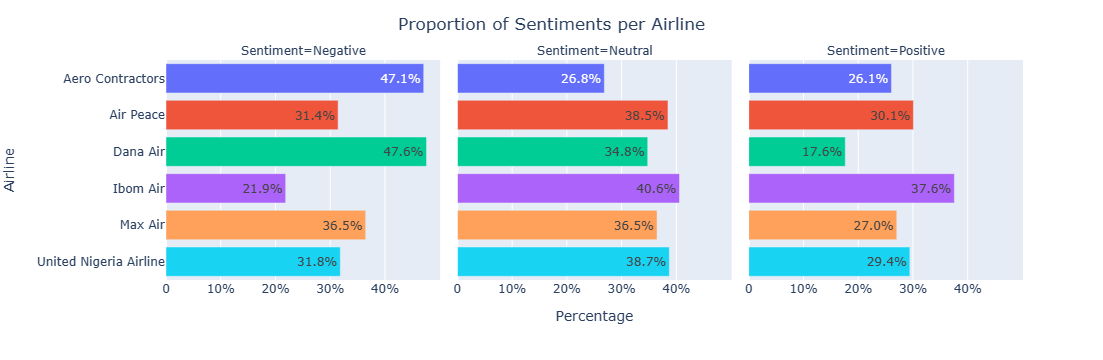

In [20]:
#horizontal bar plot to show the percentage of each sentiment category per airline 
fig = px.bar(airline_sentiment, y='Airline', x='Percentage (%)', facet_col='Sentiment', orientation='h', color='Airline', text='Percentage (%)')
fig.update_traces(texttemplate='%{text:.3s}%', textposition='inside')
fig.update_layout(title={'text':"Proportion of Sentiments per Airline", 'x':0.5}, showlegend=False)

fig.update_xaxes(tickvals=[0, 10, 20, 30, 40], ticktext=["0", "10%", "20%", "30%", "40%"])

fig.for_each_xaxis(lambda x: x.update(title = ''))
fig['layout']['xaxis2']['title']['text']='Percentage'
fig.show()

#export plot to chart studio which I will later embed in my blog post
py.plot(fig, filename="Proportion of Sentiments per Airline", auto_open = True)

### 5. Time Series Analysis <a id='time-series-analysis'></a> 

In this section, the aim was to use pandas' resample() method to perform some time series analysis to look at the average number of mentions for some airlines per specified time window over the 28-day period. I also wanted to look at how the sentiments towards some airlines changed over the 28-day period.  In order to avoid a crammed analysis, I decided to perform time series analysis for the airline with the most mentions (Air Peace) and the airline with the highest proportion of positive sentiments (Ibom Air). 
**Note that to use pandas' resample() method to view time series data over time, the datetime column of your dataset has to be set as the index.**

In [21]:
#set datetime column 'Time_Created' as index of the dataset 
df1 = df1.set_index('Time_Created')
df1.head()

Tweet_ID  \
Time_Created                               
2023-12-01 08:05:17  1730498287172493610   
2023-12-01 09:23:34  1730517986950127815   
2023-12-01 09:24:44  1730518283634274364   
2023-12-01 14:59:37  1730602557116985433   
2023-12-01 15:45:11  1730614023979147744   

                                                                  Text  Likes  \
Time_Created                                                                    
2023-12-01 08:05:17  @flyaero Please refund my money since August I...      0   
2023-12-01 09:23:34  @flyaero Good morning \n\nI booked a flight ye...      0   
2023-12-01 09:24:44  @flyaero \nI would greatly appreciate it if yo...      0   
2023-12-01 14:59:37  @flyaero I booked for a flight and ticket was ...      0   
2023-12-01 15:45:11           @TimsyMera @flyaero Did they sort this ?      0   

                     Retweets         Location           Airline Sentiment  
Time_Created                                                                
2023-12-01 08:05:17         0              ---  Aero Contractors  Negative  
2023-12-01 09:23:34         0   Abuja, Nigeria  Aero Contractors   Neutral  
2023-12-01 09:24:44         0   Abuja, Nigeria  Aero Contractors  Positive  
2023-12-01 14:59:37         0          Nigeria  Aero Contractors  Negative  
2023-12-01 15:45:11         0  On The Wheels!!  Aero Contractors   Neutral

<a id='average-mentions'></a>

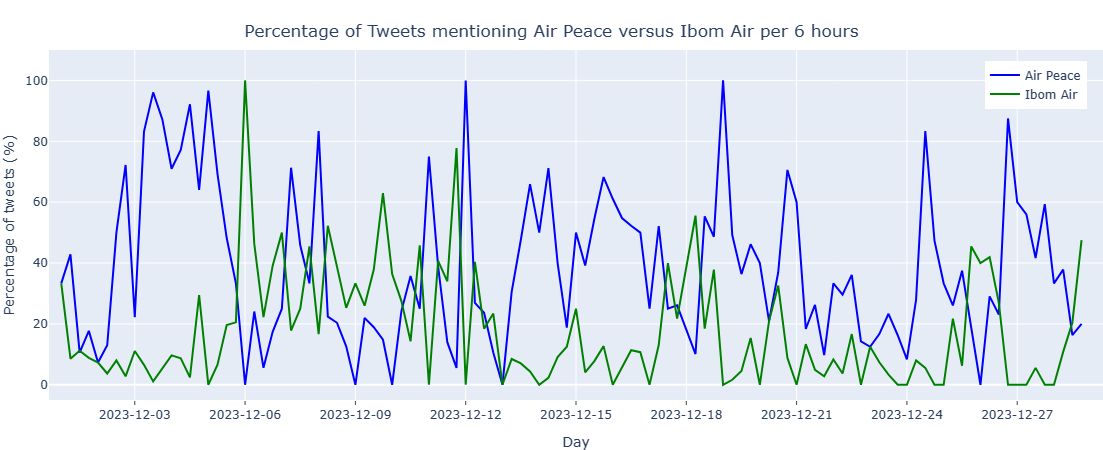

In [22]:
#plotting the percentage mean mentions of Air Peace and Ibom Air per 6 hours over the 28-day period
mean_airpeace = (df1['Airline'] == 'Air Peace').resample('6h').mean()
mean_ibomair = (df1['Airline'] == 'Ibom Air').resample('6h').mean()

fig = go.Figure(layout = go.Layout(width=1050, height=450))
fig.add_trace(go.Scatter(x=mean_airpeace.index, y=mean_airpeace*100, mode='lines', name='Air Peace', marker=dict(color='blue')))
fig.add_trace(go.Scatter(x=mean_ibomair.index, y=mean_ibomair*100, mode='lines', name='Ibom Air', marker=dict(color='green')))
fig.update_layout(title={'text':'Percentage of Tweets mentioning Air Peace versus Ibom Air per 6 hours', 'x':0.5, 'xanchor': 'center', 
                         'yanchor': 'top'}, xaxis_title='Day', xaxis=dict(tickformat='%Y-%m-%d'), yaxis_title='Percentage of tweets (%)',
                 legend = dict(x=0.888, y =0.97), yaxis=dict( range=[-5, 110]), margin=dict(r=0, t=50, l=0, b=50))
fig.update_xaxes(range =['2023-11-30 16:00:00', '2023-12-29 08:00:00'], showgrid=True, ticks="outside", tickson="boundaries", ticklen=4)   
fig.show()

#export plot to chart studio which I will later embed in my blog post
py.plot(fig, filename="Time Series Analysis - Tweet Mentions", auto_open = True)

After viewing the average mentions of the above mentioned airlines per 6 hours, I wanted to plot the average sentiment scores for the airlines per 6 hours. To do this, I needed the actual sentiment scores, ie. the digits, and not the categories - positive, negative, neutral. To get the sentiment scores, I created a function which would return the TextBlob sentiment polarity score of each tweet. 

In [23]:
#function to return the sentiment polarity score of each tweet
def get_sentiment_score(tweet):
    blob = TextBlob(tweet)
    polarity = blob.sentiment.polarity
    return polarity

In [24]:
#testing the get_sentiment_score function on some randomly selected tweets
texts = ("@flyaero didn’t disappoint me, affordable ticket with excellent customer service 🥳🥳🥳", 
         "Hello @DanaAir please check your DM asap! \n\nWhat’s with the cancelling of flight 🤷🏾‍♀️🤷🏾‍♀️🤷🏾‍♀️🤷🏾‍♀️ \n\nCc: @officialomoba",
         "@flyunitedng That’s disrespectful of you to say, na everybody dey travel like a peasant?")
for text in texts:
    print(get_sentiment_score(text))

1.0 
0.0 
-0.6999999999999998


In [25]:
#applying the get_sentiment_score function to each entry in 'Text' column and storing the result in a new column 'Sentiment_Score' 
df1['Sentiment_Score'] = df1['Text'].apply(get_sentiment_score)
df1.head()

Tweet_ID  \
Time_Created                               
2023-12-01 08:05:17  1730498287172493610   
2023-12-01 09:23:34  1730517986950127815   
2023-12-01 09:24:44  1730518283634274364   
2023-12-01 14:59:37  1730602557116985433   
2023-12-01 15:45:11  1730614023979147744   

                                                                  Text  Likes  \
Time_Created                                                                    
2023-12-01 08:05:17  @flyaero Please refund my money since August I...      0   
2023-12-01 09:23:34  @flyaero Good morning \n\nI booked a flight ye...      0   
2023-12-01 09:24:44  @flyaero \nI would greatly appreciate it if yo...      0   
2023-12-01 14:59:37  @flyaero I booked for a flight and ticket was ...      0   
2023-12-01 15:45:11           @TimsyMera @flyaero Did they sort this ?      0   

                     Retweets         Location           Airline Sentiment  \
Time_Created                                                                 
2023-12-01 08:05:17         0              ---  Aero Contractors  Negative   
2023-12-01 09:23:34         0   Abuja, Nigeria  Aero Contractors   Neutral   
2023-12-01 09:24:44         0   Abuja, Nigeria  Aero Contractors  Positive   
2023-12-01 14:59:37         0          Nigeria  Aero Contractors  Negative   
2023-12-01 15:45:11         0  On The Wheels!!  Aero Contractors   Neutral   

                     Sentiment_Score  
Time_Created                          
2023-12-01 08:05:17        -0.420625  
2023-12-01 09:23:34         0.000000  
2023-12-01 09:24:44         0.266667  
2023-12-01 14:59:37        -0.325000  
2023-12-01 15:45:11         0.000000

<a id='average-sentiments'></a>

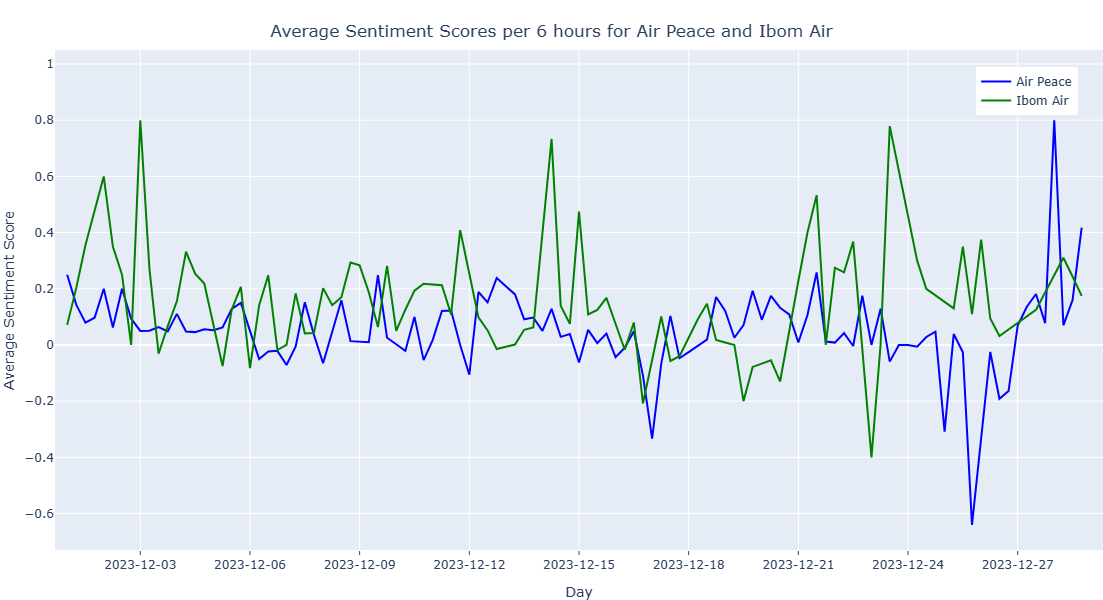

In [26]:
#plotting the average sentiment scores of Air Peace and Ibom Air per 6 hours over the 28-day period
sent_airpeace = df1.Sentiment_Score[df1['Airline'] == 'Air Peace'].resample('6h').mean()
sent_ibomair = df1.Sentiment_Score[df1['Airline'] == 'Ibom Air'].resample('6h').mean()

fig = go.Figure(layout = go.Layout(width=1050, height=600))
fig.add_trace(go.Scatter(x=sent_airpeace.index, y=sent_airpeace, mode='lines', name='Air Peace', marker=dict(color='blue')))
fig.add_trace(go.Scatter(x=sent_ibomair.index, y=sent_ibomair, mode='lines', name='Ibom Air', marker=dict(color='green')))
fig.update_layout(title={'text':'Average Sentiment Scores per 6 hours for Air Peace and Ibom Air', 'x':0.5, 'xanchor': 'center', 
                         'yanchor': 'top'}, xaxis_title='Day', xaxis=dict(tickformat='%Y-%m-%d'), yaxis_title='Average Sentiment Score',
                 legend = dict(x=0.879, y =0.966), yaxis=dict(range=[-0.73, 1.05]), margin=dict(r=0, t=50, l=0, b=50))
fig.update_xaxes(range =['2023-11-30 16:00:00', '2023-12-29 08:00:00'], showgrid=True, ticks="outside", tickson="boundaries", ticklen=4)   
fig.show()

#export plot to chart studio which I will later embed in my blog post
py.plot(fig, filename="Time Series Analysis - Sentiment Scores", auto_open = True)

**Quick point to note**: As seen from the [average sentiment scores](#average-sentiments) and [average airline mentions](#average-mentions) plots above, even though Air Peace has much more mentions than Ibom Air, the sentiment towards Ibom Air is higher. This goes to show that with social media data, having a lot of mentions or a lot of buzz does not necessarily translate to likeness for a product or company or person, etc. A subject could trend for the wrong reasons.

*Once I was done with time series analysis, I reset the dataset index*

In [27]:
df1.reset_index(inplace=True)
df1.head(3)

Time_Created             Tweet_ID  \
0 2023-12-01 08:05:17  1730498287172493610   
1 2023-12-01 09:23:34  1730517986950127815   
2 2023-12-01 09:24:44  1730518283634274364   

                                                Text  Likes  Retweets  \
0  @flyaero Please refund my money since August I...      0         0   
1  @flyaero Good morning \n\nI booked a flight ye...      0         0   
2  @flyaero \nI would greatly appreciate it if yo...      0         0   

         Location           Airline Sentiment  Sentiment_Score  
0             ---  Aero Contractors  Negative        -0.420625  
1  Abuja, Nigeria  Aero Contractors   Neutral         0.000000  
2  Abuja, Nigeria  Aero Contractors  Positive         0.266667

### 6. Tweets Processing <a id='tweets-processing'></a> 

In this step, I wanted to clean up the tweets and then look at the most common words (adjectives) used by airline passengers to describe the airlines.
I used RegEx and python's NLTK package to process the tweets. I created functions to remove stopwords, common words, punctuations, emojis, @mentions, hashtags, web adresses, digits, perform tokenization, lemmatization and then return only the adjectives using NLTK's POS-tagging.  

##### Removing web addresses, tweet mentions, hastags, digits and emojis from tweets

In [28]:
#function to remove web addresses, @mentions, hashtags, digits and emojis from tweets

def get_valid_words(tweet):
    tweet = tweet.lower()  #set all words to lowercase
   
    words = tweet.split()  #return a list of words to be able to iterate through and exclude some invalid words  
    
    invalid_words = [word for word in words if re.search('@\S+|#\S+|http\S+|www\S+', word)]  #create a list of all web addresses, @mentions, hashtags(#) in tweet
    
    numbers = [word for word in words if re.search('\d+', word)] #create a list of all digits in tweet
    
    valid_words = [word for word in words if word not in invalid_words and word not in numbers]  #remove invalid  words and numbers
    
    valid_words = " ".join(valid_words)  #join the resulting valid words with a space in between them
    
    return demoji.replace(valid_words, "") #return the valid words with all emojis taken out

In [29]:
#trying out the get_valid_words function on a random tweet
tweet = "@ibomairlines pls come through for us🙏🙏🙏 https://t.co/t3oXuzpRTA"
get_valid_words(tweet)

'pls come through for us'

In [30]:
#applying the get_valid_words function to each entry in 'Text' column and storing the result in a new column 'Words'
df1['Words'] = df1['Text'].apply(get_valid_words)
df1.head()

Time_Created             Tweet_ID  \
0 2023-12-01 08:05:17  1730498287172493610   
1 2023-12-01 09:23:34  1730517986950127815   
2 2023-12-01 09:24:44  1730518283634274364   
3 2023-12-01 14:59:37  1730602557116985433   
4 2023-12-01 15:45:11  1730614023979147744   

                                                Text  Likes  Retweets  \
0  @flyaero Please refund my money since August I...      0         0   
1  @flyaero Good morning \n\nI booked a flight ye...      0         0   
2  @flyaero \nI would greatly appreciate it if yo...      0         0   
3  @flyaero I booked for a flight and ticket was ...      0         0   
4           @TimsyMera @flyaero Did they sort this ?      0         0   

          Location           Airline Sentiment  Sentiment_Score  \
0              ---  Aero Contractors  Negative        -0.420625   
1   Abuja, Nigeria  Aero Contractors   Neutral         0.000000   
2   Abuja, Nigeria  Aero Contractors  Positive         0.266667   
3          Nigeria  Aero Contractors  Negative        -0.325000   
4  On The Wheels!!  Aero Contractors   Neutral         0.000000   

                                               Words  
0  please refund my money since august i applied ...  
1  good morning i booked a flight yesterday from ...  
2  i would greatly appreciate it if you could pro...  
3  i booked for a flight and ticket was not issue...  
4                               did they sort this ?

##### Removing stopwords, ineffective words, alphabets, punctuations and returning only adjectives

In [31]:
#CREATING LIST OF STOPWORDS, ALPHABETS, PUNCTUATIONS, INEFFECTIVE WORDS WHICH WILL BE TAKEN OUT FROM THE TWEETS 

nltk_stopwords = list(stopwords.words('english')) #list of all nltk stopwords
alphabets = list(string.ascii_lowercase) #list of all english alphabets

codepoints = range(sys.maxunicode + 1) #create a sequence of integers from 0 to the maximum unicode code point
punctuations = [c for i in codepoints if category(c := chr(i)).startswith("P")] #list of all Unicode characters that belong to the “Punctuation” category

#here I defined some ineffective words associated with airlines that would not be useful in my analysis.
common_words = ['flight', 'airline', 'airlines', 'plane', 'planes', 'airplane', 'airplanes', 'aero', 'air', 'peace', 'airpeace', 'dana', 'danaair', 'ibom', 'ibomair',
                'max', 'maxair', 'united', 'unitednigeria', 'abuja', 'lagos', 'anambra', 'owerri', 'enugu', 'uyo', 'calabar', 'akwa', 'ibom', 'maiduguri', 'sky', 'travel', 
                'class', 'board', 'trip', 'arrive', 'ticket', 'fly', 'pay', 'check-in', 'checkin', 'counter', 'service', 'welcome', 'amp', 'crew', 'cabin', 'luggage', 
                'nigerian', 'una', 'ur', 'us', 'na', 'national', 'nnamdi', 'azikiwe', 'airport', 'murtala', 'mohammed', 'international', '..', '....']

In [32]:
#    function created to tokenize the resulting words from get_valid_words function, exclude unwanted words (ie. stopwords, 
#    common words, alphabets, punctuations), lemmatize the words and then return only the adjectives using nltk's pos_tag. 
def get_adjectives(tweet):
    tweet = word_tokenize(tweet) #tokenize the tweet
    stopwords = nltk_stopwords + common_words + alphabets + punctuations #define list of all unwanted words
    tweet = [word for word in tweet if word not in stopwords] #exclude unwanted words
    
    WNlemma = WordNetLemmatizer() #create an instance of a WordNet lemmatizer
    lemmatized_words = [WNlemma.lemmatize(word) for word in tweet] #lemmatize resulting words in tweet
    
    adjectives = [word for (word, tag) in pos_tag(lemmatized_words) if tag == "JJ"] #extract only the adjectives
    return " ".join(adjectives)  

In [33]:
#trying out the get_adjectives function on a randomly selected output of the get_valid_words function
text = df1.iloc[2, 9]
print('Text: {}\n'.format(text)) 

print('After applying get_adjectives function: {}'.format(get_adjectives(text)))

Text: i would greatly appreciate it if you could provide me with the necessary flight ticket and reference number as soon as possible or advise on the steps i should take to rectify this issue promptly.

After applying get_adjectives function: necessary possible advise rectify


In [34]:
#applying the get_adjectives function to each set of words in 'Words' column and storing the result in a new column 'Adjectives' 
df1['Adjectives'] = df1['Words'].apply(get_adjectives)
df1.head()

Time_Created             Tweet_ID  \
0 2023-12-01 08:05:17  1730498287172493610   
1 2023-12-01 09:23:34  1730517986950127815   
2 2023-12-01 09:24:44  1730518283634274364   
3 2023-12-01 14:59:37  1730602557116985433   
4 2023-12-01 15:45:11  1730614023979147744   

                                                Text  Likes  Retweets  \
0  @flyaero Please refund my money since August I...      0         0   
1  @flyaero Good morning \n\nI booked a flight ye...      0         0   
2  @flyaero \nI would greatly appreciate it if yo...      0         0   
3  @flyaero I booked for a flight and ticket was ...      0         0   
4           @TimsyMera @flyaero Did they sort this ?      0         0   

          Location           Airline Sentiment  Sentiment_Score  \
0              ---  Aero Contractors  Negative        -0.420625   
1   Abuja, Nigeria  Aero Contractors   Neutral         0.000000   
2   Abuja, Nigeria  Aero Contractors  Positive         0.266667   
3          Nigeria  Aero Contractors  Negative        -0.325000   
4  On The Wheels!!  Aero Contractors   Neutral         0.000000   

                                               Words  \
0  please refund my money since august i applied ...   
1  good morning i booked a flight yesterday from ...   
2  i would greatly appreciate it if you could pro...   
3  i booked for a flight and ticket was not issue...   
4                               did they sort this ?   

                          Adjectives  
0                                     
1          good email spam necessary  
2  necessary possible advise rectify  
3                   issued seek mean  
4

### 7. Word Cloud<a id='word-cloud'></a>

The aim for the word cloud was to show the adjectives used to describe the airlines. Since I had already extracted the adjectives from each tweet in the [Tweets Processing](#tweets-processing) step above, all I had to do was group the adjectives for each airline together. I created a function **airline_adjectives** to do this.

In [35]:
#function to return adjectives for any selected airline
def airline_adjectives(airline):
    x = df1[df1['Airline'] == airline]  #to select only entries for the specified airline
    all_adjectives = x['Adjectives'].tolist() #return a list of all the adjectives used to describe the airline
    
    y = " ".join(all_adjectives) #to join each element in the list of adjectives together, with a space in between
    
    text = " ".join(y.split()) #  to take care of the cases where there were no adjectives in the 'Adjectives' column, 
                               #  which resulted in multiple spaces in some positions in y
    return text

In [36]:
#how the airline_adjectives function works
#using the airline_adjectives function to get all the adjectives used to describe Air Peace
airpeace = airline_adjectives('Air Peace')
airpeace

"global undue fraudulent monopoly serious crash lagos/abuja empty sure slash hard domestic waybill sabi find avoid warmth eh jor several parallel shld want various abt administratn diff survive salah break emailed guy ask last incentive wrong poor sha sufficient direct igboman gross fellow dear portal warri like festive light willing close avoid big small resemble disappointed hear pregnant ugo card delayed on-time give want want urgent terminal small rush know panic wa o. sudan free patriotic priority lag-owerri ademola sent january due cat kill esi nma ask alone getaway december perfect blend rome montreal whole leonardo say past sure bean schedule on-time awesome uk explain operated equal pas operated reliable omo interested africa great plastic full bad entire safe good happy new delayed political wicke-dness pm prior former presidential dr. chief ozekome dear next warri btw compensate excess former presidential dr. chief ozekome real safe southern cheap last cancelled delayed hard

In [37]:
#using the airline_adjectives function to get all the adjectives used to describe Ibom Air
ibomair = airline_adjectives('Ibom Air')
ibomair

'unprofessional single official big endless important deadline incur additional pick free davido reveal exclusive great tour nice wide continuous several blue nice november impressive summary on-time send great dm delayed high delayed public top reliable please serious former right sef know delay exceptional fifteen itinerary similar email right perfect remo back robert sikiru bombastic top seaport intelligent threw new new smile delightful new happy new happy new exciting hear yeye ak tho ak multiple nso ntom happy new ojota warri lucrative davido easy exclusive new concert great grand obo memorable new concert new regular new new concert sharp want lucky special timeless concert okay easy exclusive new concert great top new concert sure good lucky new know possible last inspite nice dey concert regional vegetable see swear crazy differential essien udim rich cultural udim essien udim rich cultural udim several urgent operate different fight essien udim rich cultural udim inefficient 

##### Creating the Word Cloud

After getting the adjectives used to describe the airlines, it was time to plot the word cloud. Since this analysis was about airlines, I wanted to create the word cloud to have an aeroplane shape outline. I acheived this by superimposing the word cloud unto a mask of an aeroplane shape. I imported the mask (as an image), converted it into a numpy array, and then using the WordCloud package, superimposed the words unto the mask.  

I created functions to define the colormaps for the word cloud (ie to specify the colours to be used). I also created a function that would plot the word cloud for any specified airline.

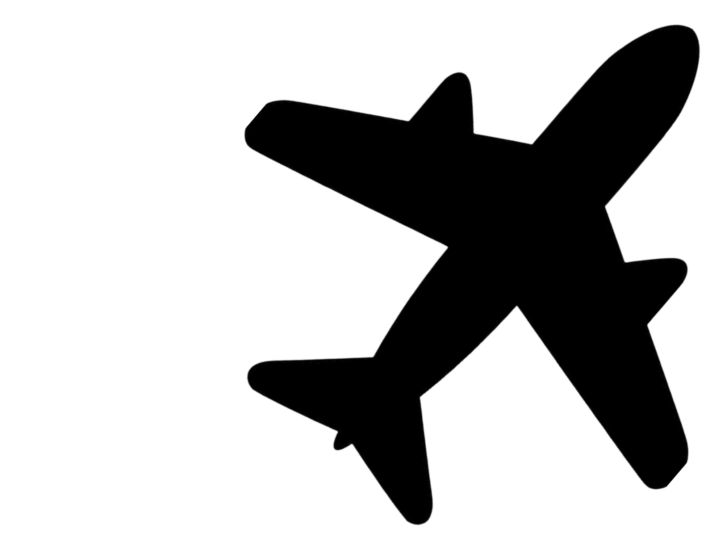

In [38]:
image = np.array(Image.open(r"C:\Users\ogech\Documents\aeroplane.png"))  #import the image mask 
fig = plt.figure(figsize=(9, 13))  #specify the figure size

#show the image
plt.imshow(image, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis('off')
plt.show()

In [39]:
#functions to specify the colours to be used 
def blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return("hsl(240, 100%, {}%)".format(random.randint(35, 50)))  #return different shades of blue colour
   

def green_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return("hsl(120, 100%, {}%)".format(random.randint(20, 35)))  #return different shades of green colour
    

In [40]:
#function to plot the word cloud for any airline option
def plot_word_cloud(airline_name, color, colorx): 
    
    text_data = airline_adjectives(airline_name) #genetate the adjectives for the specified airline using the airline_adjectives function already created

    x = WordCloud(background_color = "white", mask=image, collocations=False)  #instantiate a word cloud object
    x = x.generate(text_data)  #generate the word cloud
    x.recolor(color_func = color)  #specify the colour(s)
    
    fig = plt.figure(figsize=(9, 13))  #set up the word cloud figure
    
    #set and design the title 
    plt.text(0.26, 1.05, 'Word Cloud for most common', color='black', fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.62, 1.05, 'words', color=colorx, fontsize=12, transform=plt.gca().transAxes)
    plt.text(0.70, 1.05, 'used to describe' + ' ' + airline_name, color='black', fontsize=12, transform=plt.gca().transAxes)
    
    #display the word cloud
    plt.imshow(x, interpolation='bilinear')
    plt.axis('off')
    plt.show() 

   #plt.savefig(airline_name + ' ' + 'wordcloud.png') #save as png file to include in my blog post

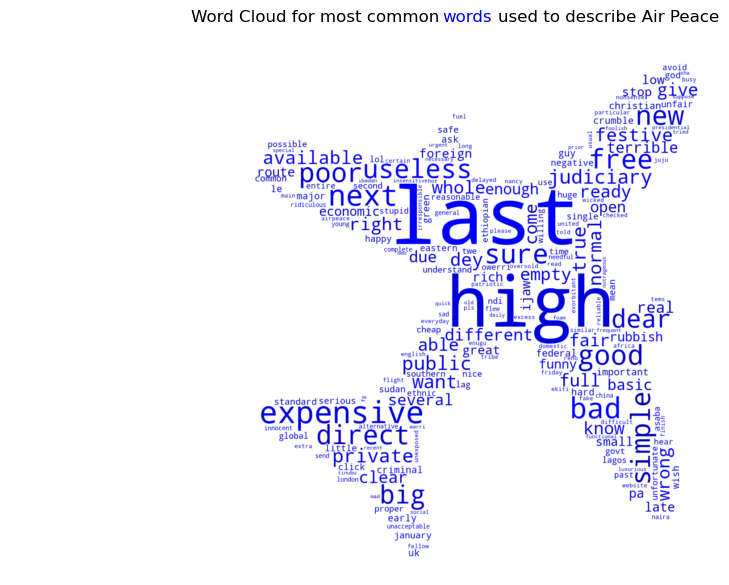

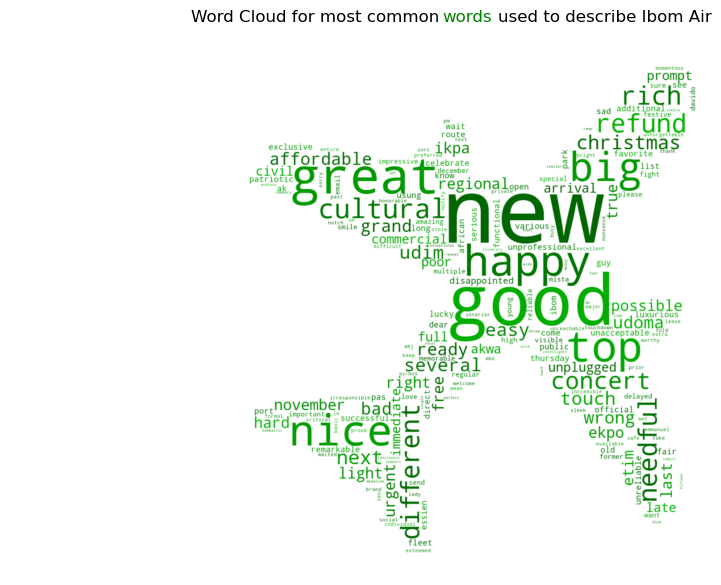

In [41]:
#using the plot_word_cloud function to plot word cloud of the most common words used to describe Air Peace and Ibom Air
plot_word_cloud('Air Peace', blue_color_func, 'blue')
plot_word_cloud('Ibom Air', green_color_func, 'green')

##### Most Common Words

The word cloud for Air Peace shows that some of the most common words used to describe the airline are: last, high, expensive, direct, good.
For Ibom Air, we have: new, good, great, top, happy.

To validate this, I created a function **top_5** to return (in descending order) the top 5 words used to describe any airline option.

In [42]:
#function to return the top 5 words (in descending order) used to describe a selected airline
def top_5(airline):
    text = airline_adjectives(airline)  #use the airline_adjectives function previously created to return the adjectives 
    dist = FreqDist(word_tokenize(text)) #  returns a dictionary containing the all the words in 'text' and their frequency 
                                         #  distribution. Note that starting from NLTK version 3.0.0, FreqDist now returns the 
                                         #  words in descending order of frequency.
    
    top_5_words = list(dist)[:5]    #returns the 5 most common words
    return (', '.join(top_5_words)) #returns each item in the top_5_words list separated by a comma and then a space

In [43]:
#using the top_5 function to return the 5 most common words used to describe Air Peace and Ibom Air
print('The top 5 words used to describe Air Peace are: {}.'.format(top_5('Air Peace')))
print('The top 5 words used to describe Ibom Air are: {}.'.format(top_5('Ibom Air')))

The top 5 words used to describe Air Peace are: last, high, expensive, next, bad.
The top 5 words used to describe Ibom Air are: new, good, great, nice, happy.


At this point, I was done with my analysis and it was time to store the resulting dataset as csv for use in creating a Tableau dashboard. Preview the head of my final dataset before export.

In [44]:
df1.head()

Time_Created             Tweet_ID  \
0 2023-12-01 08:05:17  1730498287172493610   
1 2023-12-01 09:23:34  1730517986950127815   
2 2023-12-01 09:24:44  1730518283634274364   
3 2023-12-01 14:59:37  1730602557116985433   
4 2023-12-01 15:45:11  1730614023979147744   

                                                Text  Likes  Retweets  \
0  @flyaero Please refund my money since August I...      0         0   
1  @flyaero Good morning \n\nI booked a flight ye...      0         0   
2  @flyaero \nI would greatly appreciate it if yo...      0         0   
3  @flyaero I booked for a flight and ticket was ...      0         0   
4           @TimsyMera @flyaero Did they sort this ?      0         0   

          Location           Airline Sentiment  Sentiment_Score  \
0              ---  Aero Contractors  Negative        -0.420625   
1   Abuja, Nigeria  Aero Contractors   Neutral         0.000000   
2   Abuja, Nigeria  Aero Contractors  Positive         0.266667   
3          Nigeria  Aero Contractors  Negative        -0.325000   
4  On The Wheels!!  Aero Contractors   Neutral         0.000000   

                                               Words  \
0  please refund my money since august i applied ...   
1  good morning i booked a flight yesterday from ...   
2  i would greatly appreciate it if you could pro...   
3  i booked for a flight and ticket was not issue...   
4                               did they sort this ?   

                          Adjectives  
0                                     
1          good email spam necessary  
2  necessary possible advise rectify  
3                   issued seek mean  
4

In [45]:
#save the cleaned dataset 
df1.to_csv("Nigerian_Airline_Passengers'_Tweets.csv", index = False)

### THANK YOU FOR GOING THROUGH MY NOTEBOOK !!